<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/11_beta_binomial.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(mcmc-bayes-inference-notebook)=
# Inferenza bayesiana con PyMC

In questo capitolo, faremo uso di [PyMC](https://www.pymc.io/welcome.html), una libreria Python specializzata nella modellazione statistica bayesiana. A differenza del capitolo precedente, in cui abbiamo utilizzato le funzioni di scipy.stats, qui ricorreremo a un Linguaggio di Programmazione Probabilistico (PPL) per implementare il nostro campionatore. L'uso di PPL semplifica notevolmente l'attuazione dell'inferenza bayesiana, permettendo agli utenti di focalizzarsi sulla costruzione del modello e liberandoli da dettagli matematici e computazionali. 

Nel contesto di questa metodologia avanzata, in questo e nei successivi capitoli esploreremo i modelli a un parametro. Questi modelli rappresentano una classe di distribuzioni campionarie identificate da un unico parametro sconosciuto. In particolare, ci concentreremo sull'inferenza bayesiana applicata a due tipi di modelli a un parametro: il modello binomiale e il modello di Poisson. Oltre ad essere utili strumenti statistici, questi modelli forniscono anche un ambiente semplice all'interno del quale è possibile apprendere le basi dell'analisi dei dati bayesiana, incluse le distribuzioni a priori coniugate, le distribuzioni predittive e le regioni di confidenza.

## Campionatore No-U-Turn

L'algoritmo Metropolis, che abbiamo esaminato in precedenza, offre un metodo per generare campioni da distribuzioni di probabilità attraverso la creazione di una catena di Markov, con la distribuzione desiderata come distribuzione di equilibrio (o stazionaria). Tuttavia, per modelli complessi, tale algoritmo può risultare inefficiente e richiedere un tempo considerevole per convergere verso una distribuzione stazionaria. Per affrontare questa sfida, sono stati sviluppati algoritmi Monte Carlo a catena di Markov (MCMC) più efficienti, tra cui il campionatore No-U-Turn (NUTS), gli algoritmi Metropolis-Hastings, il campionatore Gibbs e il campionatore Hamiltonian Monte Carlo. Questi algoritmi sono stati implementati in vari PPL, tra cui [PyMC](https://peerj.com/articles/cs-1516.pdf) e Stan {cite}`carpenter2017stan`.

Nel presente capitolo useremo PyMC per condurre l'inferenza sulle proporzioni binomiali.

Iniziamo a caricare i pacchetti necessari.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import xarray as xr
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Un esempio pratico di utilizzo del linguaggio probabilistico PyMC consiste nell'eseguire una semplice operazione aritmetica. Iniziamo a sommare due numeri interi in Python.

In [3]:
# adding 2 integers in Python
a = 2
b = 3
c = a + b
print(c)

5


Facciamo ora la stessa cosa usando PyMC.

In [4]:
# adding 2 random variables in PyMC
with pm.Model() as example:
    a = pm.Normal("a", 2, 0.5)
    b = pm.Normal("b", 3, 0.2)
    c = pm.Deterministic("c", a + b)
    trace_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


```python
with pm.Model() as example:
```
In questa linea, viene creato un nuovo modello probabilistico PyMC utilizzando un contesto Python `with`. All'interno di questo contesto, tutte le variabili casuali e le operazioni definite saranno automaticamente associate al modello chiamato `example`.

```python
a = pm.Normal("a", 2, 0.5)
```
Qui viene definita una variabile casuale normalmente distribuita con un valore medio ($\mu$) di 2 e una deviazione standard ($\sigma$) di 0.5. Questa variabile è denominata "a".

```python
b = pm.Normal("b", 3, 0.2)
```
Qui viene definita un'altra variabile aleatoria normalmente distribuita, ma questa volta con un valore medio di 3 e una deviazione standard di 0.2. Questa variabile è denominata "b".

```python
c = pm.Deterministic("c", a + b)
```
In questa linea, viene creata una nuova variabile deterministica "c" che è definita come la somma delle variabili "a" e "b". Essendo una variabile deterministica, il suo valore è completamente determinato dai valori di "a" e "b".

```python
trace_1 = pm.sample()
```
Infine, questa linea avvia il processo di campionamento MCMC (Monte Carlo Markov Chain) per generare un campione dalla distribuzione a posteriori del modello. Il risultato del campionamento è salvato in un oggetto chiamato `trace_1`, che contiene le tracce delle variabili aleatorie durante il campionamento.

Per rappresentare graficamente i risultati del processo di campionamento, possiamo utilizzare la funzione `plot_trace()` fornita dalla libreria ArviZ. Questa funzione crea un diagramma delle tracce che visualizza sia la serie temporale dei valori campionati (traccia) sia la loro distribuzione.

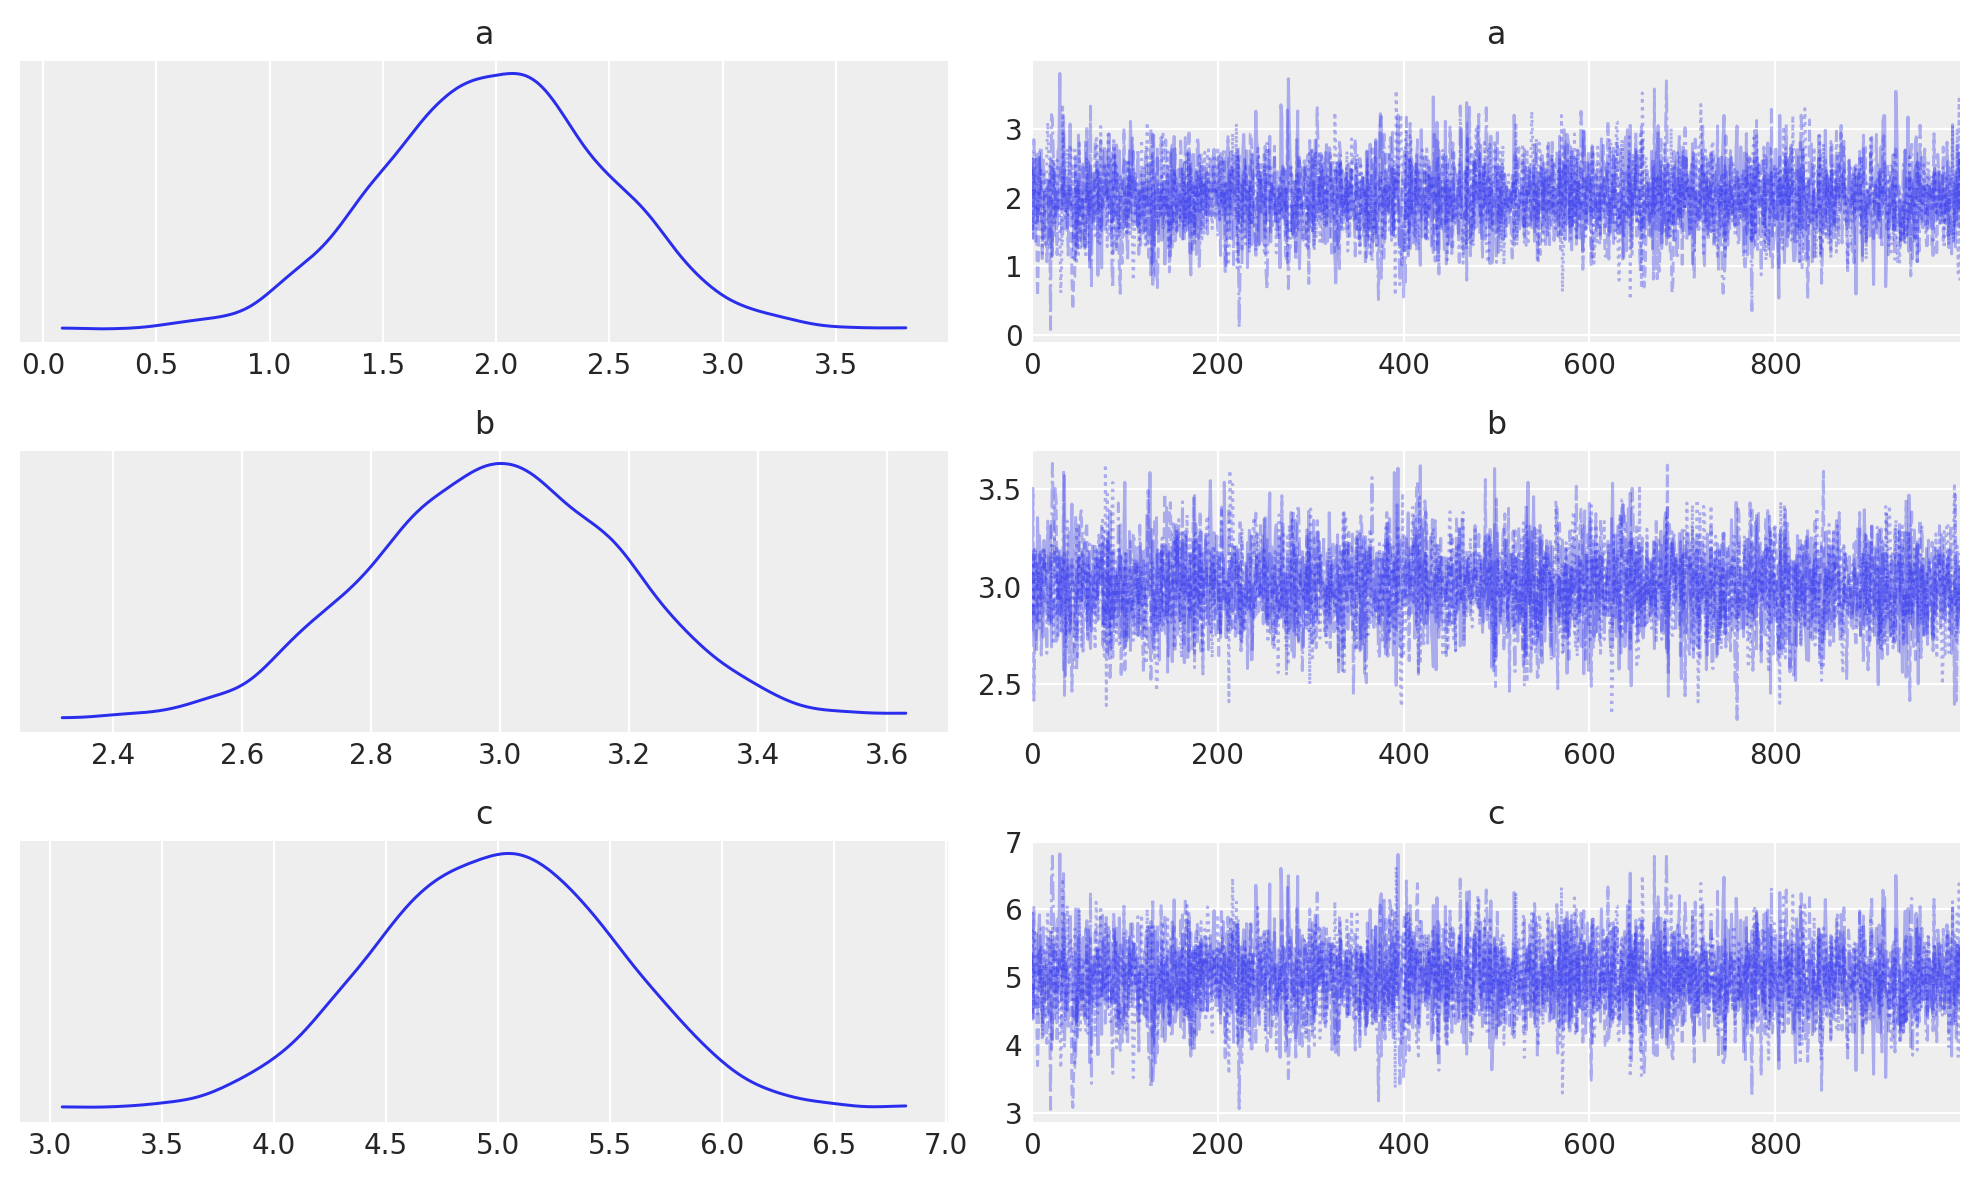

In [5]:
az.plot_trace(trace_1, figsize=(10, 6), combined=True)
plt.tight_layout()

Il grafico delle tracce illustra che la moda della distribuzione a posteriori della variabile $c$ corrisponde al risultato che prevedevamo.

## Generazione X

Ora analizzeremo un caso di inferenza basata su dati reali, in contrapposizione alla situazione deterministica esaminata precedentemente. Prenderemo nuovamente in esame i dati discussi nel capitolo precedente, relativi agli artisti della Generazione X rappresentati al MOMA. Ricordiamo che abbiamo registrato 14 successi su 100 tentativi e abbiamo basato il parametro $ \theta $ (la probabilità di appartenere alla Generazione X o a generazioni successive) su una distribuzione Beta(4, 6).

Il nostro modello, quindi, si articola come segue:

$$
\begin{align*}
\theta &\sim \text{Beta}(4, 6), \\
y &\sim \text{Bin}(n, \theta).
\end{align*}
$$

In questa impostazione, la prima riga definisce la distribuzione a priori, $p(\theta)$, mentre la seconda riga determina la funzione di verosimiglianza, $p(y_1, \ldots, y_{100} | \theta)$.

Nel caso presente abbiamo deciso di rappresentare la nostra incertezza a priori rispetto al parametro $ \theta $ mediante una Beta(4, 6).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


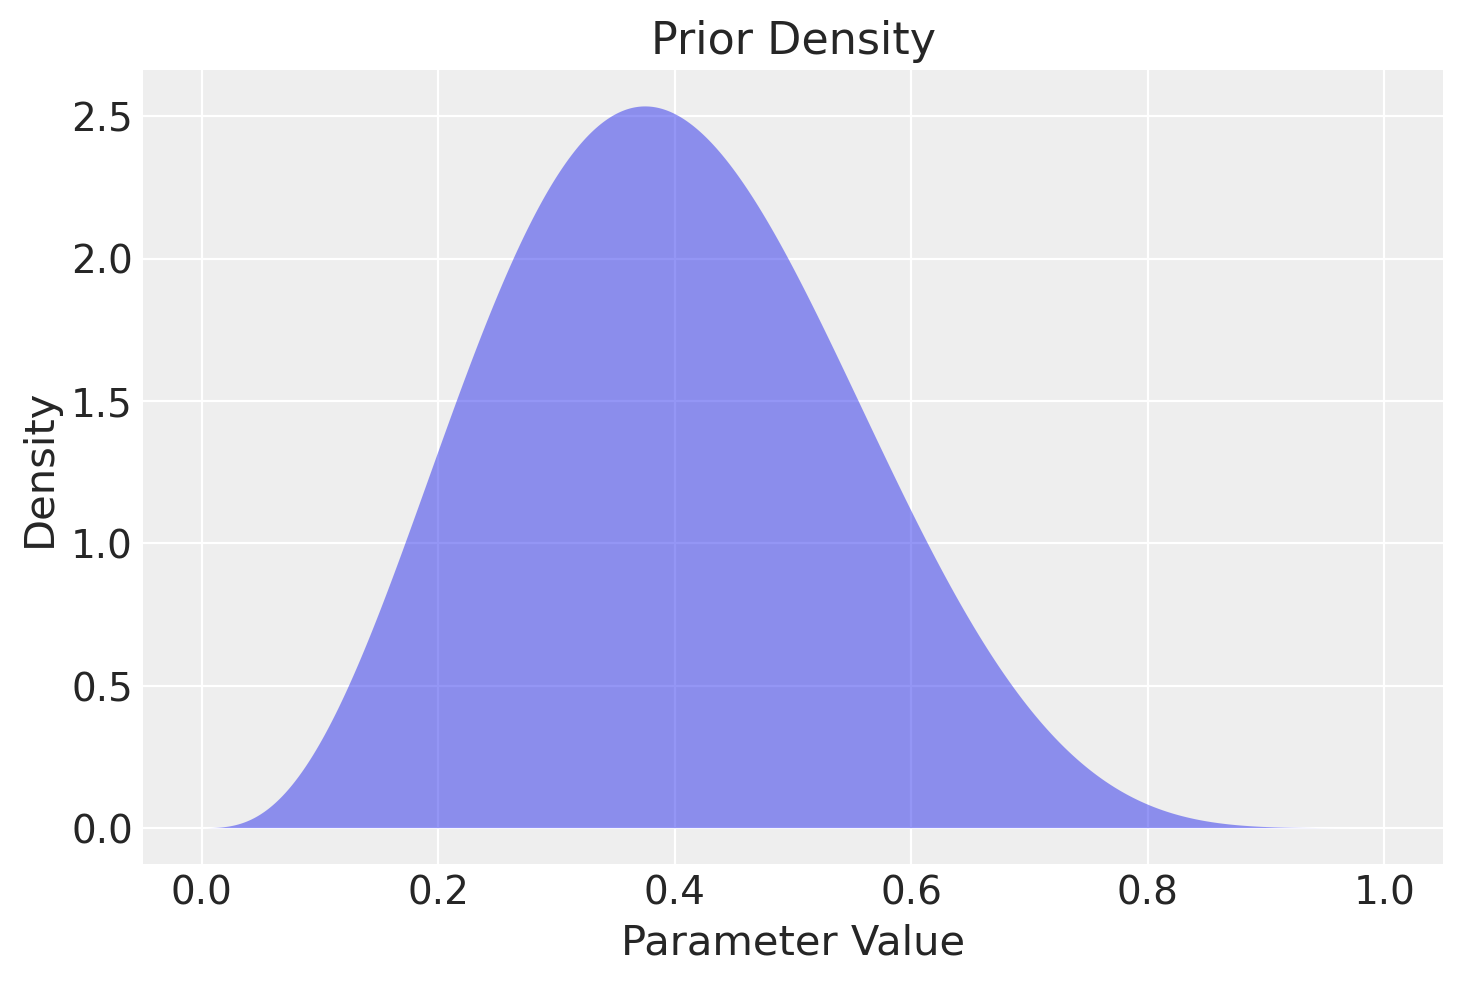

In [6]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)

plt.fill_between(x, prior_density, alpha=0.5)
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior Density");

Per questa distribuzione a priori e il modello di campionamento sopra indicato, la regola di Bayes fornisce

$$
\begin{align*}
p(\theta \mid y_1, \ldots, y_{100}) &= \frac{p(y_1, \ldots, y_{100} \mid \theta) p(\theta)}{p(y_1, \ldots, y_{100})} \\
&\propto p(y_1, \ldots, y_{100} \mid \theta) p(\theta) \\
&\propto \prod_{i=1}^{100} p(y_i \mid \theta) p(\theta),
\end{align*}
$$

dove $p(y_i \mid \theta)$ è la distribuzione bernoulliana

$$
p(Y = y \mid \theta) = \theta^y (1-\theta)^{1-y}
$$

e $p(\theta)$ è una distribuzione Beta(4,6).

Nel contesto specifico che stiamo analizzando, è possibile trovare una soluzione analitica per stimare la distribuzione a posteriori. Per esempio, se $ y = 14 $ e $ n = 100 $, la distribuzione a posteriori sarà una Beta(18, 92). Infatti, la distribuzione Beta è un "prior coniugato" per la distribuzione binomiale, il che significa che se iniziamo con un prior Beta e osserviamo dati che seguono una distribuzione binomiale, il posterior sarà ancora una distribuzione Beta. 

La formula per aggiornare i parametri della distribuzione Beta a posteriori $ \text{Beta}(\alpha', \beta') $ a partire da un prior $ \text{Beta}(\alpha, \beta) $ e dati binomiali con $ y $ successi e $ n $ prove è la seguente:

$$
\alpha' = \alpha + y
$$
$$
\beta' = \beta + n - y
$$

Nel nostro caso, $ \alpha = 4 $, $ \beta = 6 $, $ y = 14 $, e $ n = 100 $. Utilizzando queste formule:

$$
\alpha' = 4 + 14 = 18
$$
$$
\beta' = 6 + 100 - 14 = 92
$$

otteniamo che la distribuzione a posteriori è una $ \text{Beta}(18, 92) $.

Sebbene in questo caso particolare possiamo facilmente ottenere una soluzione analitica per la distribuzione a posteriori, tale opportunità è rara nella maggior parte dei modelli di inferenza bayesiana. Spesso, per gestire modelli più complessi, è necessario ricorrere a tecniche di approssimazione numerica, come i metodi MCMC. Nell'esempio qui discusso, applicheremo i metodi MCMC a un caso per il quale abbiamo già una soluzione analitica, permettendoci così di confrontare i risultati derivati dall'approccio analitico con quelli ottenuti attraverso l'approssimazione numerica.

### Dedurre una proporzione con PyMC

Adesso eseguiremo l'analisi che abbiamo precedentemente condotto utilizzando l'algoritmo di Metropolis usando PyMC. Assumiamo di avere già installato il pacchetto PyMC. Una volta installato, dovremo importare le librerie necessarie, tra cui Matplotlib, Numpy, Scipy, Arviz e ovviamente PyMC stesso.

Esamineremo ora come specificare il modello beta-binomiale attraverso PyMC. Per condurre l'analisi tramite PyMC, sarà prima necessario delineare la struttura del modello bayesiano e, successivamente, eseguire il campionamento dalla distribuzione a posteriori. Approfondiremo entrambi questi passaggi nell'ambito del nostro esempio.

### Dati

In [8]:
y = 14
ntrials = 100

### Distribuzione a priori

I parametri della distribuzione Beta, scelta come distribuzione a priori per $\theta$, sono i seguenti.

In [9]:
alpha_prior = 4
beta_prior = 6

## Creazione del Modello

La libreria PyMC utilizza il costrutto `with` di Python per creare un ambiente all'interno del quale possiamo definire le variabili aleatorie, le loro distribuzioni e le relazioni tra di esse. In questo esempio, illustreremo come utilizzare PyMC attraverso un modello di distribuzione binomiale con un prior Beta.

In [10]:
with pm.Model() as bb_model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

### Inizializzazione

Il primo passo nella creazione del modello è l'uso della sintassi `with pm.Model() as bb_model:`. Questa linea di codice utilizza il meccanismo dei contesti manager in Python per instanziare un modello probabilistico con PyMC.

- **pm.Model()**: Crea un nuovo ambiente di modello probabilistico. Questo ambiente funge da contenitore per variabili aleatorie, distribuzioni e relazioni tra variabili.
- **as bb_model**: Assegna l'ambiente di modello a una variabile Python chiamata `bb_model`, facilitando le interazioni future con il modello.

### Variabili aleatorie e distribuzioni
Nel linguaggio di PyMC, le variabili aleatorie (Random Variables, RV) sono i mattoni fondamentali di un modello probabilistico. Una RV può essere definita da una distribuzione di probabilità, come la distribuzione normale o la distribuzione binomiale.

- **Definizione del prior**: All'interno dell'ambiente di modello, utilizziamo `pm.Beta` per definire una variabile aleatoria chiamata `theta` che rappresenta la distribuzione a priori. Gli iperparametri `alpha_prior` e `beta_prior` definiscono i parametri della distribuzione Beta.

```python
theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
```

- **Definizione della verosimiglianza**: Oltre ai priori, abbiamo bisogno di definire una funzione di verosimiglianza che collega i nostri dati osservati al modello. In questo esempio, utilizziamo una distribuzione binomiale per la verosimiglianza. La variabile `y` rappresenta i dati osservati e `ntrials` il numero totale di prove.

```python
obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
```

### Variabili osservate e non osservate
Nel modello, ogni variabile aleatoria può essere o osservata o non osservata:

- **Variabili non osservate**: Come `theta`, sono variabili aleatorie il cui valore non è noto e viene stimato dal modello.
- **Variabili osservate**: Come `obs`, sono variabili aleatorie per le quali abbiamo dati osservati. Questi dati sono passati utilizzando l'argomento `observed`.

### Relazioni gerarchiche
Infine, le variabili aleatorie possono essere utilizzate come parametri per altre variabili aleatorie, stabilendo una relazione "genitore-figlio". Nel nostro esempio, la variabile `theta` (genitore) è utilizzata come parametro per la variabile `obs` (figlio), creando una relazione gerarchica.

Con questo modello, abbiamo un sistema coerente e interconnesso che possiamo utilizzare per eseguire inferenze bayesiane, stime di parametri o previsioni.

Visualizziamo la struttura del modello.

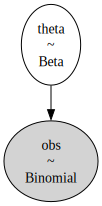

In [11]:
pm.model_to_graphviz(bb_model)

### Contenitori di dati

I dati possono essere incorporati in un modello PyMC attraverso vari metodi, che includono array multidimensionali di NumPy, serie e DataFrame di Pandas, e anche TensorVariables di PyTorch. Sebbene sia possibile introdurre questi formati di dati "grezzi" direttamente nel modello PyMC, l'approccio più consigliato è quello di utilizzare uno dei due contenitori di dati specifici forniti da PyMC: `pymc.ConstantData()` e `pymc.MutableData()`. Come suggeriscono i loro nomi, solo `MutableData` permette modifiche ai dati dopo la loro inizializzazione. L'utilizzo di `pymc.MutableData()` è particolarmente vantaggioso quando si vuole aggiornare i dati senza la necessità di ricostruire l'intero modello. Questa flessibilità si rivela estremamente utile in scenari come analisi in tempo reale o esperimenti computazionali iterativi. Per gli scopi di questo insegnamento, un contenitore di dati immutabile come `pymc.ConstantData()` è generalmente sufficiente.

Nell'esempio precedente, abbiamo inserito dati "non elaborati" in PyMC. Ora esploreremo come utilizzare un contenitore di dati. In questa versione aggiornata del modello, creiamo un contenitore `pm.ConstantData` per contenere le osservazioni e passiamo tale contenitore come parametro all'argomento `observed`. Creiamo inoltre un contenitore `pm.ConstantData` per contenere il parametro che specifica il numero di prove e lo passiamo all'argomento `n`.

In [12]:
with pm.Model() as bb_model:
    y_data = pm.ConstantData("y_data", y)
    n_trials = pm.ConstantData("n_trials", ntrials)
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=n_trials, observed=y_data)

Poiché abbiamo utilizzato il contenitore `pm.ConstantData`, i dati compaiono ora nel nostro grafo probabilistico. Questo grafo distingue tra variabili endogene (vale a dire, le variabili "a valle" che rappresentano gli effetti delle cause nel modello, e verso cui puntano le frecce) ed esogene (ossia le variabili "a monte" che sono all'origine della generazione dei dati; da queste variabili partono le frecce orientate). Le variabili ombreggiate in grigio sono quelle che sono state osservate. Le forme rettangolari con angoli arrotondati evidenziano che si tratta di dati inclusi nel modello.

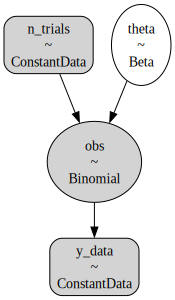

In [11]:
pm.model_to_graphviz(bb_model)

### Inferenza

Avendo completamente specificato un modello probabilistico, possiamo selezionare un metodo appropriato per l'inferenza. Questo potrebbe essere una semplice ottimizzazione, dove troviamo le stime del massimo a posteriori per tutti i parametri del modello.

In [13]:
with bb_model:
    fit = pm.find_MAP()

In [14]:
fit["theta"]

array(0.15740746)

In alternativa all'ottimizzazione per la ricerca del massimo a posteriori (MAP), possiamo optare per un approccio completamente bayesiano e utilizzare il metodo Markov chain Monte Carlo (MCMC) per adattare il modello. Questa tecnica produce una traccia di valori campionati, rappresentando la distribuzione marginale a posteriori di tutti i parametri del modello. La funzione `sample` fornisce l'interfaccia per tutti i metodi MCMC disponibili in PyMC.

Nel contesto della programmazione probabilistica con PyMC, il campionamento MCMC è reso particolarmente semplice. Ad esempio, se desideriamo ottenere 1.000 campioni a posteriori dopo aver calibrato il campionatore per 1.000 iterazioni, possiamo effettuare una chiamata come la seguente:

In [15]:
with bb_model:
    idata = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


### Metodi di inferenza in PyMC: da Metropolis a NUTS

Nel contesto della modellazione probabilistica, una volta definito il modello completo, il passo successivo è l'inferenza. Abbiamo precedentemente introdotto l'idea del campionamento Markov chain Monte Carlo (MCMC) discutendo dell'algoritmo di Metropolis. Tuttavia, in PyMC, l'implementazione del campionamento MCMC è ulteriormente semplificata e potenziata attraverso l'uso dell'algoritmo No-U-Turn Sampler (NUTS), una variante avanzata del Metropolis.

La funzione `sample` in PyMC è il cuore del processo di campionamento. Essa esegue il metodo di campionamento `step` specificato o quello predefinito per un numero dato di iterazioni. Ad esempio, il codice precedente specifica che desideriamo 1.000 campioni a posteriori con un periodo iniziale di *burn-in* di 1.000 iterazioni.

Notabilmente, la funzione `sample` è in grado di generare più catene di campionamento in parallelo, a seconda del numero di core di calcolo presenti sul computer. Ad esempio, su una macchina con 4 core, vengono eseguite 4 catene in parallelo, generando in totale 8.000 campioni dopo un periodo di *burn-in* di 4.000 iterazioni.

I risultati del processo di campionamento sono salvati in un oggetto chiamato `InferenceData`, che è un formato dati specialmente progettato per l'analisi bayesiana. Esso contiene non solo i campioni a posteriori, ma anche una varietà di altre informazioni utili, come statistiche del campionamento, dati osservati e diagnostiche. L'oggetto è costruito sulla libreria xarray, permettendo una manipolazione dati sofisticata.

Nel processo di campionamento, l'algoritmo MCMC adatta iterativamente la distribuzione a priori del parametro $\theta$ in base ai campioni generati nelle iterazioni precedenti. Dopo un numero sufficiente di iterazioni, che garantiscono la convergenza dell'algoritmo, i campioni possono essere considerati rappresentativi della distribuzione a posteriori.

È importante notare che all'inizio del processo di campionamento, la distribuzione dei campioni potrebbe non essere rappresentativa della distribuzione a posteriori. Questa fase iniziale, conosciuta come *burn-in*, generalmente richiede che i campioni vengano scartati per evitare stime imprecise.

La durata del processo di campionamento è influenzata dalla potenza di calcolo disponibile. Con hardware più potente, il campionamento e la convergenza possono essere raggiunti più rapidamente.

Una rappresentazione grafica della distribuzione a posteriori di $\theta$ può essere ottenuta con `plot_posterior`.

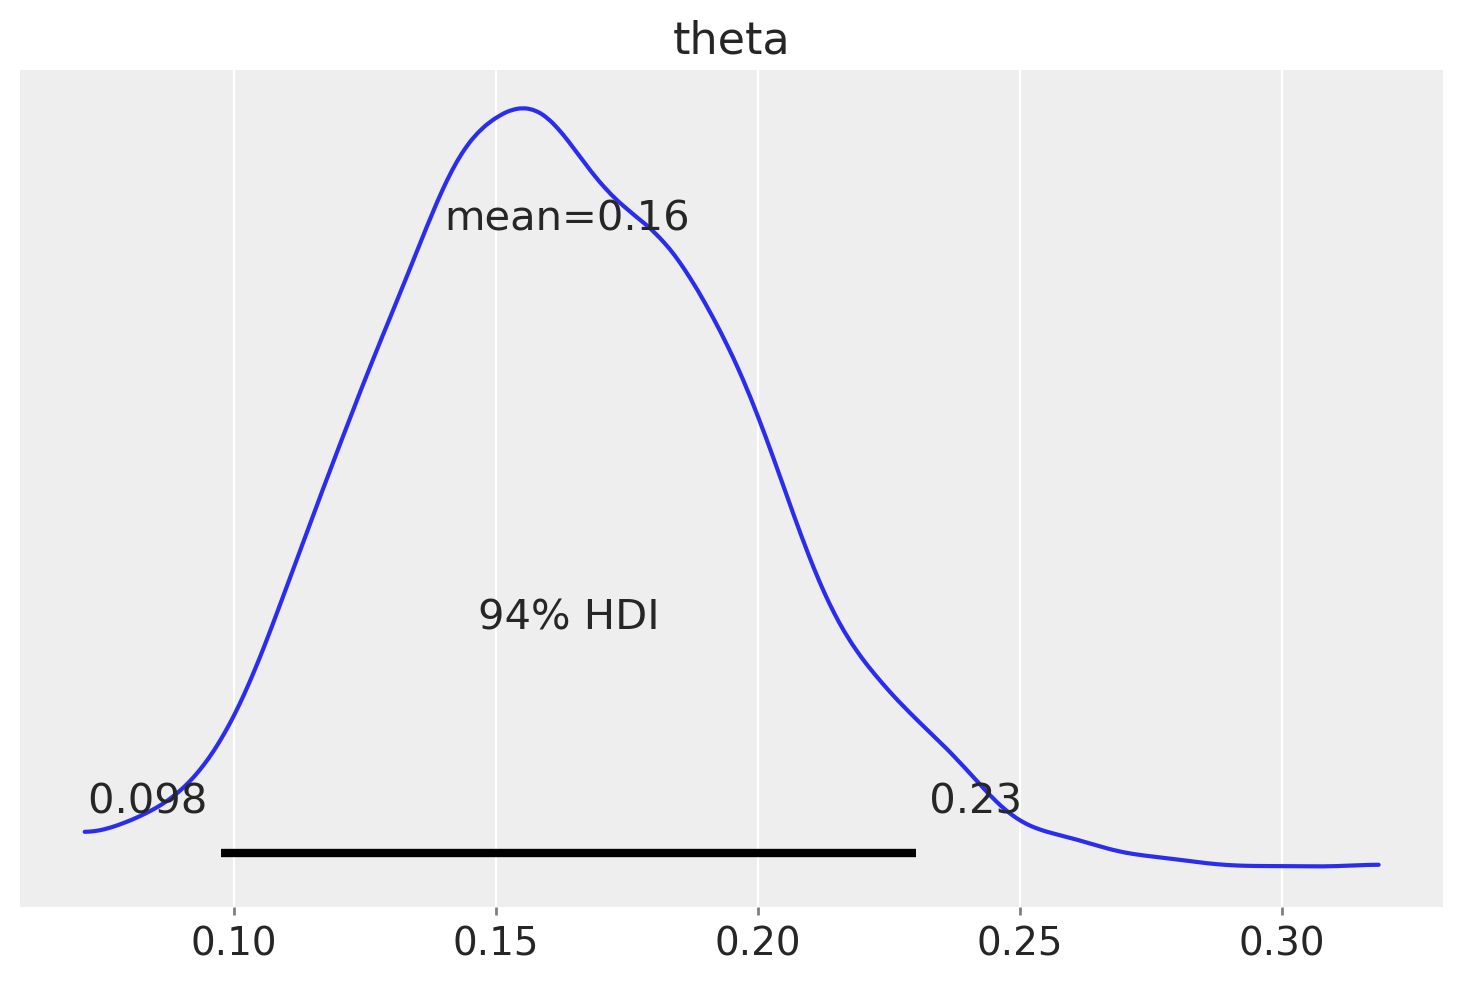

In [16]:
az.plot_posterior(idata);

### Utilizzo dell'Algoritmo Metropolis

Per fare un esempio, se vogliamo optare per l'utilizzo dell'algoritmo di campionamento Metropolis anziché NUTS, che rappresenta l'impostazione predefinita, possiamo specificarlo come argomento "step" per la funzione "sample".

In [17]:
with bb_model:
    metropolis_idata = pm.sample(step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


La distribuzione a posteriori è praticamente identica a quella ottenuta in precedenza.

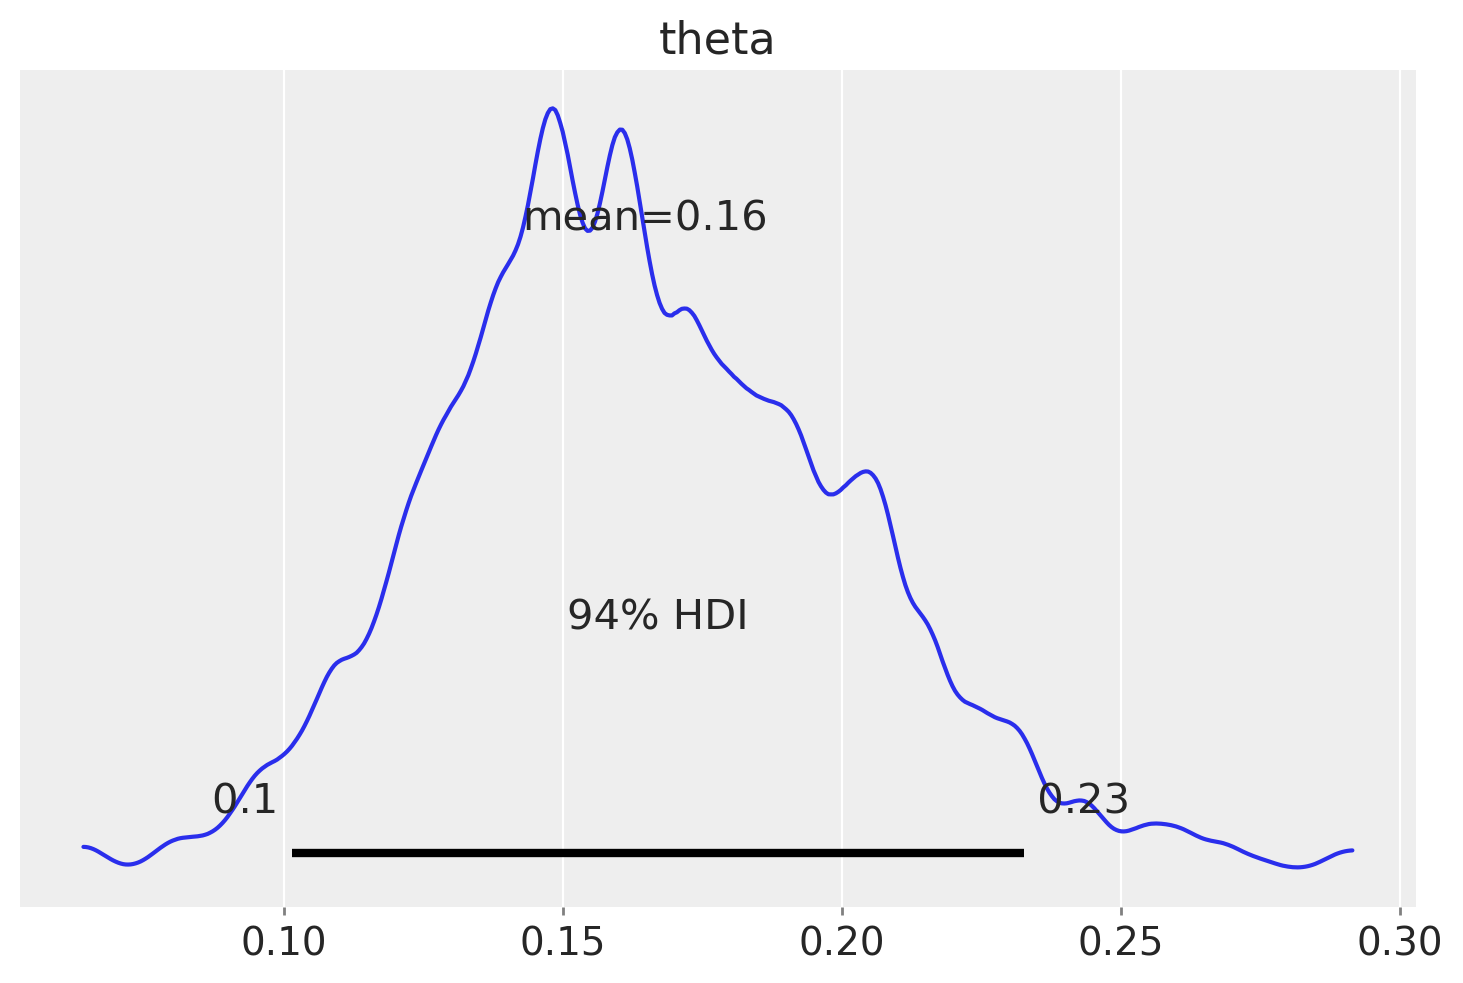

In [18]:
_ = az.plot_posterior(metropolis_idata)

Un tracciato della catena di Markov illustra questa esplorazione rappresentando il valore $\theta$ sulle ordinate e l'indice progressivo di in ogni iterazione sull'ascissa. Il trace plot è estremamente utile per valutare la convergenza di un algoritmo MCMC e se è necessario escludere un periodo di campioni iniziali (noto come burn-in). Per produrre la traccia chiamiamo semplicemente `az.plot_trace()` con la variabile `idata`:

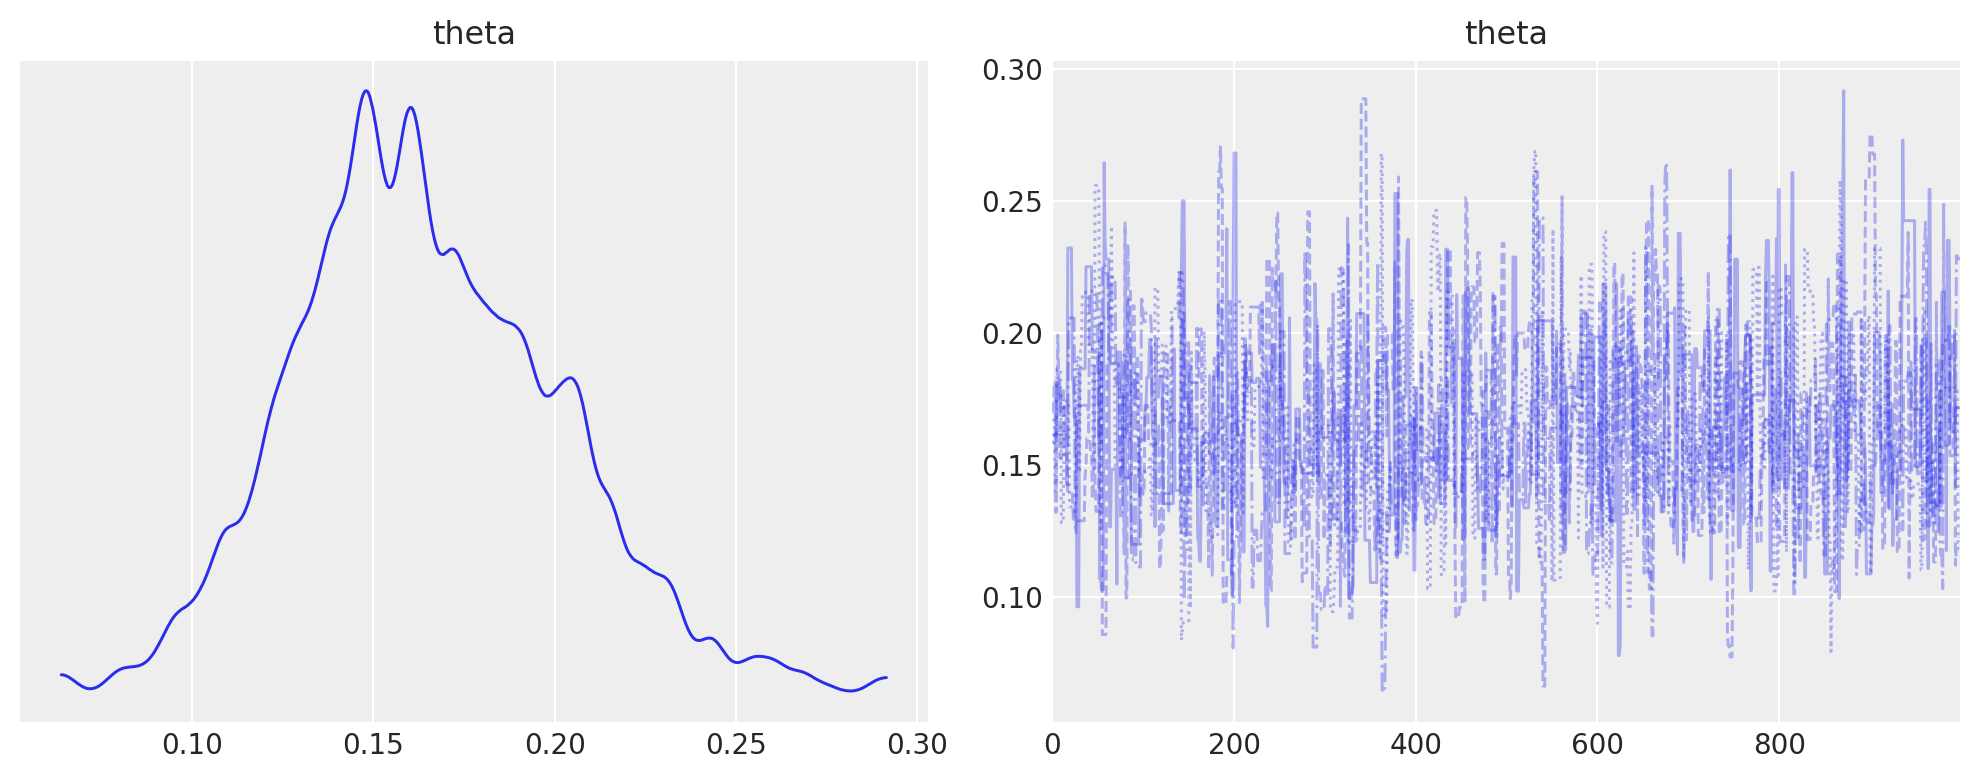

In [19]:
az.plot_trace(metropolis_idata, combined=True, figsize=(10, 4))
plt.tight_layout()
plt.show()

Per combinare catene e iterazioni, utilizziamo la funzione `arviz.extract()`. Creiamo un oggetto `DataArray` di Xarray chiamato `post`.

In [20]:
post = az.extract(metropolis_idata)
post

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (sample) float64 0.1586 0.1586 0.1586 0.1586 ... 0.228 0.228 0.228
Attributes:
    created_at:                 2023-11-14T22:14:31.164021
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.2
    sampling_time:              26.015729904174805
    tuning_steps:               1000

In [23]:
post["theta"].shape

(4000,)

Nella figura successiva sono presentate sia la distribuzione a posteriori ottenuta tramite il metodo MCMC, sia quella derivata analiticamente. 

Text(0, 0.5, 'Densità')

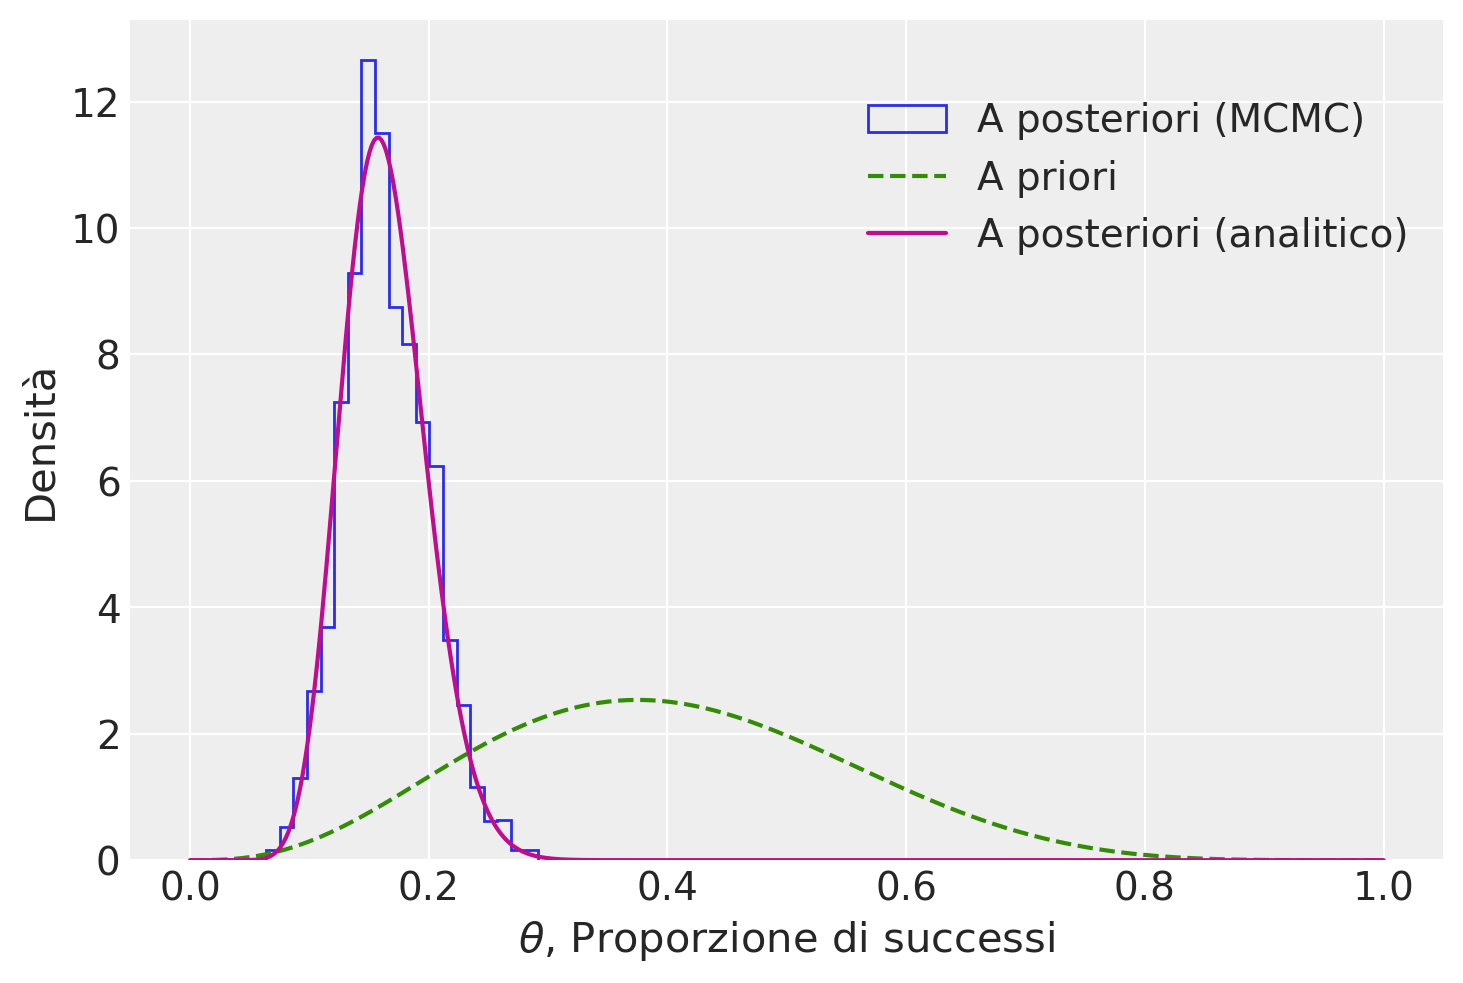

In [22]:
p_post = post["theta"]

# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + ntrials - y

plt.hist(
    p_post,
    bins=20,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="C0",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 500)
plt.plot(
    x, stats.beta.pdf(x, alpha_prior, beta_prior), "--", label="A priori", color="C2"
)
plt.plot(
    x,
    stats.beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="C3",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità")

Si può osservare la coerenza tra le due soluzioni: l'istogramma segue da vicino la distribuzione a posteriori calcolata analiticamente, come da previsione.

## L'oggetto `InferenceData` in PyMC

L'oggetto che si ottiene come risultato del processo di campionamento in PyMC è un'istanza della classe `InferenceData`. Questo formato di dati specializzato è basato su xarray, un pacchetto per la manipolazione di array N-dimensionali. Progettato specificamente per gestire l'output del campionamento MCMC, l'oggetto `InferenceData` archivia non solo i valori campionati, ma anche altre informazioni diagnostiche utili generate durante l'esecuzione del campionamento.

Una delle principali funzionalità di `InferenceData` è la sua compatibilità con la libreria ArviZ, che è ampliamente utilizzata per la visualizzazione e la sintesi di modelli bayesiani. Questa integrazione facilita la presentazione del modello stimato sia in forma tabellare che grafica.

Ora, esaminiamo più dettagliatamente l'oggetto `InferenceData`. Questo formato non solo permette una facile manipolazione dei dati campionati, ma anche fornisce un'interfaccia intuitiva per accedere a varie metriche e diagnostiche necessarie per la valutazione del modello.

In [26]:
metropolis_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

L'oggetto `InferenceData` è ispirato dallo standard NetCDF, un formato largamente adottato per salvare array multidimensionali su file. Oltre alla memorizzazione dei dati, il formato NetCDF supporta anche la gestione dei metadati e organizza i dati in "gruppi". L'oggetto `InferenceData` in esame è diviso in quattro gruppi principali: `posterior`, `sample_stats`, `observed_data` e `constant_data` (dato che abbiamo passato a PyMC i dati mediante il contenitore `pm.ConstantData`). Ciascuno di questi gruppi è implementato come un `xarray.Dataset`. 

### Caratteristiche di un `xarray.Dataset`

Un `xarray.Dataset` è una struttura dati che rappresenta una collezione coordinata di array multidimensionali. Per approfondire, si può consultare questo [tutorial](https://tutorial.xarray.dev/intro.html). Un `xarray.Dataset` si compone di alcune componenti chiave:

1. **Variabili Dati (`Data variables`)**: Sono gli array multidimensionali che contengono i dati reali. Ad esempio, nel gruppo `posterior`, `theta` è una variabile dati.

2. **Coordinate (`Coordinates`)**: Etichettano i dati e consentono un accesso più diretto e intuitivo agli array. Per esempio, nel gruppo `posterior`, `chain` e `draw` sono coordinate.

3. **Attributi (`Attributes`)**: Sono i metadati che forniscono informazioni aggiuntive sul dataset, come la data di creazione o la versione della libreria di inferenza utilizzata.

Gli oggetti `xarray.Dataset` funzionano come contenitori simili a dizionari di `DataArray`, associando un nome di variabile a ciascun `DataArray`. È possibile accedere ai "livelli" del Dataset (cioè ai singoli `DataArray`) attraverso una sintassi simile a quella di un dizionario.

Ad esempio, consideriamo il gruppo `posterior` nel nostro oggetto `InferenceData`.

In [31]:
post = metropolis_idata.posterior
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (chain, draw) float64 0.1542 0.1542 0.1542 ... 0.1783 0.1783 0.1783
Attributes:
    created_at:                 2023-09-08T06:01:54.603198
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              23.551659107208252
    tuning_steps:               1000

Estraiamo `theta`.

In [28]:
post["theta"]

<xarray.DataArray 'theta' (chain: 4, draw: 1000)>
array([[0.1295584 , 0.15670614, 0.16719343, ..., 0.14867141, 0.13246263,
        0.13246263],
       [0.13819429, 0.13819429, 0.13819429, ..., 0.16838166, 0.16838166,
        0.16838166],
       [0.13748773, 0.13748773, 0.20721518, ..., 0.23630801, 0.23630801,
        0.23630801],
       [0.20791716, 0.15353609, 0.1482075 , ..., 0.11033288, 0.11194824,
        0.11194824]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [29]:
post["theta"].shape

(4, 1000)

La classe `DataArray` è costituita da un array (dati) e dai corrispondenti nomi delle dimensioni, etichette e attributi (metadati).  

Per accedere direttamente all'array dei dati usiamo il metodo `.data`:

In [30]:
post["theta"].data

array([[0.1295584 , 0.15670614, 0.16719343, ..., 0.14867141, 0.13246263,
        0.13246263],
       [0.13819429, 0.13819429, 0.13819429, ..., 0.16838166, 0.16838166,
        0.16838166],
       [0.13748773, 0.13748773, 0.20721518, ..., 0.23630801, 0.23630801,
        0.23630801],
       [0.20791716, 0.15353609, 0.1482075 , ..., 0.11033288, 0.11194824,
        0.11194824]])

Le dimensioni (`.dims`) sono gli assi dei dati. Nel caso presente abbiamo le catene (`chain`) e i campioni a posteriori (`draw`).

In [31]:
post["theta"].dims

('chain', 'draw')

Le coordinate (`.coords`) forniscono una mappatura tra i nomi delle coordinate e i valori.

In [30]:
post["theta"].coords

Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

Per trasformare un array bidimensionale in un array unidimensionale in Python, è possibile utilizzare il metodo `reshape` di NumPy. 

In [31]:
# Trasformazione in un array unidimensionale
theta_1d = post["theta"].data.reshape(-1)
theta_1d

array([0.22160781, 0.13102291, 0.13102291, ..., 0.12947174, 0.12947174,
       0.12947174])

Le statistiche descrittive di interesse possono essere calcolate sull'array unidimensionale che abbiamo creato:

In [37]:
np.mean(theta_1d)

0.16393486433679363

Oppure possono essere calcolate direttamente sugli array bidimensionali che distringuono tra `chain` e `draw`:

In [40]:
np.mean(post["theta"].data)

0.16393486433679363

## Panoramica dell'architettura di PyMC

### Moduli e componenti

PyMC è organizzato in una serie di moduli che, pur essendo quasi indipendenti, sono interconnessi e supportano la modellazione bayesiana. Questi moduli includono componenti fondamentali come modelli e distribuzioni di probabilità, vari algoritmi di inferenza e anche elementi più avanzati.

### Distribuzioni

PyMC dispone di un'ampia gamma di distribuzioni di probabilità, sia quelle comunemente usate che altre più specializzate, tutte implementate come classi separate.

### Gestione del modello

Il modulo `Model` offre la classe `Model`, che ingloba tutti gli aspetti del modello bayesiano definito dall'utente. L'interazione con un'istanza del modello si svolge tramite un gestore di contesto, che facilita l'aggiunta automatica di variabili al modello e l'instaurazione di relazioni tra esse, come le relazioni genitore-figlio tra variabili aleatorie.

### Step Methods

Per le distribuzioni continue, il campionatore predefinito è basato sul No-U-Turn Sampler (NUTS). Tuttavia, gli utenti hanno la possibilità di sovrascrivere manualmente questo algoritmo predefinito.

### Campionamento e funzioni ausiliarie

PyMC non solo supporta vari metodi MCMC, ma permette anche il campionamento dalle distribuzioni predittive a priori e a posteriori. Inoltre, offre la flessibilità di utilizzare la stessa definizione del modello sia per calcolare le distribuzioni a posteriori che per quelle predittive, senza necessità di ulteriori interventi da parte dell'utente.

## Commenti e considerazioni finali 

Questo capitolo ha illustrato come utilizzare PyMC per ottenere la distribuzione a posteriori quando ci troviamo di fronte a un caso di distribuzione beta-binomiale, caratterizzato dalle relazioni di verosimiglianza binomiale e dalla distribuzione a priori Beta. Inoltre, è stata condotta un'analisi comparativa tra la soluzione ottenuta tramite PyMC e la soluzione analitica del problema discusso, dimostrando la convergenza tra i due approcci.

## Watermark

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 14 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

seaborn   : 0.13.0
xarray    : 2023.10.1
scipy     : 1.11.3
arviz     : 0.16.1
numpy     : 1.25.2
pymc      : 5.9.2
matplotlib: 3.8.1

Watermark: 2.4.3

